# HU-LLM-Text Mistral Large: PhonologyBench for Russian 

Inspired by [PhonologyBench: Evaluating Phonological Skills of Large Language Models](https://aclanthology.org/2024.knowllm-1.1/) (Suvarna et al., KnowLLM 2024). 


## Part 1: Counting syllables in words

The idea is to test how good is HU-LLM in counting syllables in Russian words. I took words with different number of syllables from [this web](https://slogi.su/1). I expect it to be quite good in this task as there is a clear algorithm how to identify a syllable in a Russian word. 

The preprocessed files with words are located in `words_folder`. The code below: 

- reads each file from the folder
- counts how many words are in each file 
- creates a big csv with all words and syllables count

In [2]:
import os
import pandas as pd
dfs = {}

folder_path = "/Users/maria.onoeva/Desktop/new_folder/GitHub/nlp-repo/HU_LLM/words_folder"

# Loop through all .txt files in the folder as above
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(folder_path, filename)

        with open(file_path, 'r') as file:
            words = file.read().split(', ')
            length = len(words)

        print(f"Words in {filename}: {length}")

        # Create a DataFrame
        df = pd.DataFrame(words, columns=['word'])

        # Extract syllable count from filename (e.g., 'words_3.txt' -> 3)
        syllable_count = int(''.join([d for d in filename if d.isdigit()]))

        # Add the syllable count column
        df['syllable'] = syllable_count

        # Store in dictionary using filename without extension as key
        key = os.path.splitext(filename)[0]
        dfs[key] = df

# combine all DataFrames into one big one
combined_df = pd.concat(dfs.values(), ignore_index=True)

# saving as csv
combined_df.to_csv('combined_df.csv') 

Words in words_8.txt: 208
Words in words_9.txt: 144
Words in words_4.txt: 286
Words in words_5.txt: 278
Words in words_7.txt: 257
Words in words_6.txt: 272
Words in words_2.txt: 296
Words in words_3.txt: 298
Words in words_1.txt: 270


In [3]:
combined_df.count()

word        2309
syllable    2309
dtype: int64

Now I create 4 random samples of 250 words from the big csv and prompt it to HU-LLM via its API (1000 in one batch seems to be too much). 

In [4]:
import numpy as np

sample_df_1000 = combined_df.sample(n=1000, random_state=420)

# Split into 4 approximately equal parts
split_dfs = np.array_split(sample_df_1000, 4)

# If you want lists instead of DataFrames:
split_lists = [subdf['word'].tolist() for subdf in split_dfs]

# Access the 4 random non-overlapping lists:
list1, list2, list3, list4 = split_lists

/Users/maria.onoeva/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [5]:
sample_df_1000.to_csv('sample_df_1000.csv')

In [51]:
from gradio_client import Client

for i in split_lists: 
    client = Client("https://llm1-compute.cms.hu-berlin.de/")
    result_list = client.predict(
		param_0=f"Please count syllables in these Russian words {i}",
		api_name="/chat"
)
    with open("sample_1000_result.txt", "a") as file:
        file.write(result_list)


Loaded as API: https://llm1-compute.cms.hu-berlin.de/ ✔
Loaded as API: https://llm1-compute.cms.hu-berlin.de/ ✔
Loaded as API: https://llm1-compute.cms.hu-berlin.de/ ✔
Loaded as API: https://llm1-compute.cms.hu-berlin.de/ ✔


Before assessing the results, I need to clean the result file `sample_1000_result.txt`. I manually removed all except results and saved to a new file `sample_1000_result_clean.txt`. Now I also need to remove numbers and replace `' - '` pattern with comma. Saving to `cleaned_output.csv`.

In [6]:
import re

pattern1 = re.compile(r"\d+\.\s") # this will remove a number from the beginning of the line
pattern2 = re.compile(r"\s*-\s*") # replaces " - " pattern 

cleaned_rows = []

with open("sample_1000_result_clean.txt", "r") as file:
    for line in file:
        line = pattern1.sub("", line)
        line = pattern2.sub(",", line)
        cleaned_line = line.strip()
        row = cleaned_line.split(",")  # split into columns
        cleaned_rows.append(row)

# Create DataFrame and save to CSV
cleaned_output = pd.DataFrame(cleaned_rows)
cleaned_output.to_csv("cleaned_output.csv", index=False, header=False)

In [7]:
cleaned_output.count()

0    1000
1    1000
dtype: int64

## Stat 
Now finally, I can compare the output. 

In [8]:
# because the dfs were not combined properly, I had to drop their initial indices 
sample_df_1000 = sample_df_1000.reset_index(drop=True)
cleaned_output = cleaned_output.reset_index(drop=True)

ready_df = pd.concat([sample_df_1000, cleaned_output], ignore_index=True, axis=1) # combining for comparison
ready_df[3] = ready_df[3].astype(int) # making the third column as int
ready_df[4] = ready_df[1] == ready_df[3] # comparing columns 
ready_df[5] = ready_df[0] == ready_df[2] # comparing columns 
false_ready_df = ready_df.loc[ready_df[4]!=True].copy() # extracting False
false_ready_df[6] = false_ready_df[1]-false_ready_df[3] # counting difference
ready_df.head()

Plotting raw results. 

Todo: 
- all stat
- part of speech tagging

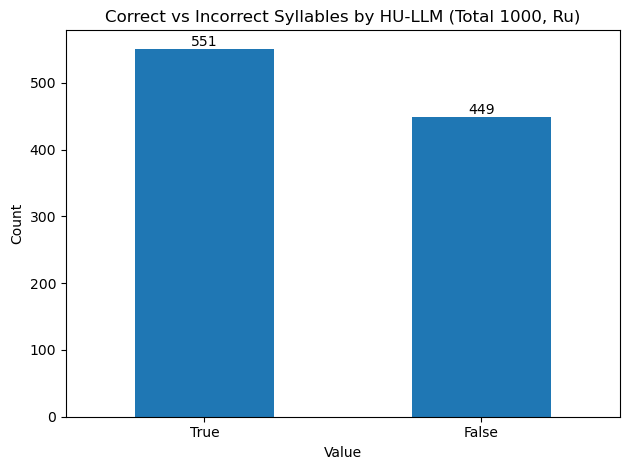

In [18]:
import matplotlib.pyplot as plt
# Count occurrences of True and False
counts = ready_df[4].value_counts()

# Plot as bar chart
ax = counts.plot(kind='bar')
plt.title('Correct vs Incorrect Syllables by HU-LLM (Total 1000, Ru)')
plt.xlabel('Value')
plt.ylabel('Count')
plt.xticks(ticks=[0,1], labels=['True', 'False'], rotation=0)
# Annotate each bar with its value
for i, v in enumerate(counts):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Well, 449 wrong hits is too much!!! What is going on? Is it because those words are super infrequent? Now I want to know per each prompt how much was wrong.

In [123]:
split_ready_df = np.array_split(ready_df, 4)
attempt1 = split_ready_df[0][4].mean()
attempt2 = split_ready_df[1][4].mean()
attempt3 = split_ready_df[2][4].mean()
attempt4 = split_ready_df[3][4].mean()

print(attempt1, attempt2, attempt3, attempt4)

0.624 0.484 0.572 0.524


/Users/maria.onoeva/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [19]:
ready_df.head()

,0,1,2,3,4,5
0,зонтик,2,зонтик,2,True,True
1,макроэкономический,8,макроэкономический,8,True,True
2,неодинаково,6,неодинаково,6,True,True
3,топсайдеры,4,топсайдеры,4,True,True
4,щавеля,3,щавеля,3,True,True


 ### Checking for normality

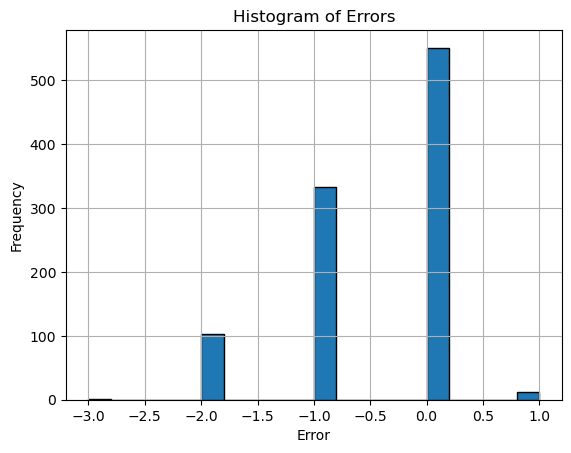

In [21]:
errors = ready_df[3] - ready_df[1] # Difference between measured (output from LLM) and baseline (syllables from web)

plt.hist(errors, bins=20, edgecolor='black')
plt.title('Histogram of Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

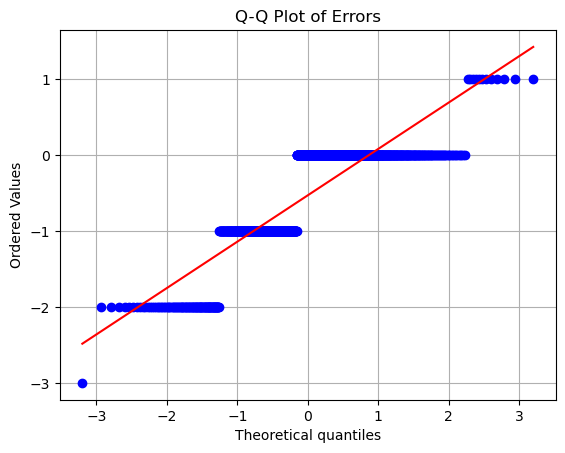

In [22]:
import scipy.stats as stats

stats.probplot(errors, dist="norm", plot=plt)
plt.title('Q-Q Plot of Errors')
plt.grid(True)
plt.show()

In [24]:
from scipy.stats import shapiro
from scipy.stats import kstest

stat, p = shapiro(errors)
print(f"Shapiro-Wilk test: W = {stat:.3f}, p = {p:.3f}")

stat, p = kstest(errors, 'norm', args=(errors.mean(), errors.std()))
print(f"K-S test: D = {stat:.3f}, p = {p:.3f}")


Shapiro-Wilk test: W = 0.765, p = 0.000
K-S test: D = 0.340, p = 0.000


I am a bit worried that my data are not normally distributed. On top of that, I have discrete data (i.e., integers) and not continuous data, so I decided to use non-parametric test.

### Freq stat

In [39]:
import numpy as np
from scipy.stats import pearsonr

# Assuming your DataFrame has these columns:
baseline = ready_df[1].values
measured = ready_df[3].values
errors = measured - baseline

# Metrics
mean_baseline = np.mean(baseline)
mean_measured = np.mean(measured)
bias = np.mean(errors)
mae = np.mean(np.abs(errors))
rmse = np.sqrt(np.mean(errors**2))
std_dev = np.std(errors)
r, p_value = pearsonr(baseline, measured)

# Display results
print(f"Mean baseline: {mean_baseline:.3f}")
print(f"Mean measured: {mean_measured:.3f}")
print(f"Mean(baseline) - Mean(measured): {mean_measured - mean_baseline:.3f}")
print(f"Mean(baseline - measured): {np.mean(measured-baseline):.3f}")
print(f"Mean error (bias): {bias:.3f}")
print(f"MAE (mean absolute error): {mae:.3f}")
print(f"RMSE (root mean squared error): {rmse:.3f}")
print(f"Standard deviation of errors: {std_dev:.3f}")
print(f"Pearson correlation: r = {r:.3f}, p = {p_value:.3f}")


Mean baseline: 4.662
Mean measured: 4.132
Mean(baseline) - Mean(measured): -0.530
Mean(baseline - measured): -0.530
Mean error (bias): -0.530
MAE (mean absolute error): 0.554
RMSE (root mean squared error): 0.875
Standard deviation of errors: 0.696
Pearson correlation: r = 0.972, p = 0.000


### Bayesian stat 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>,
       <Axes: title={'center': 'nu'}>], dtype=object)

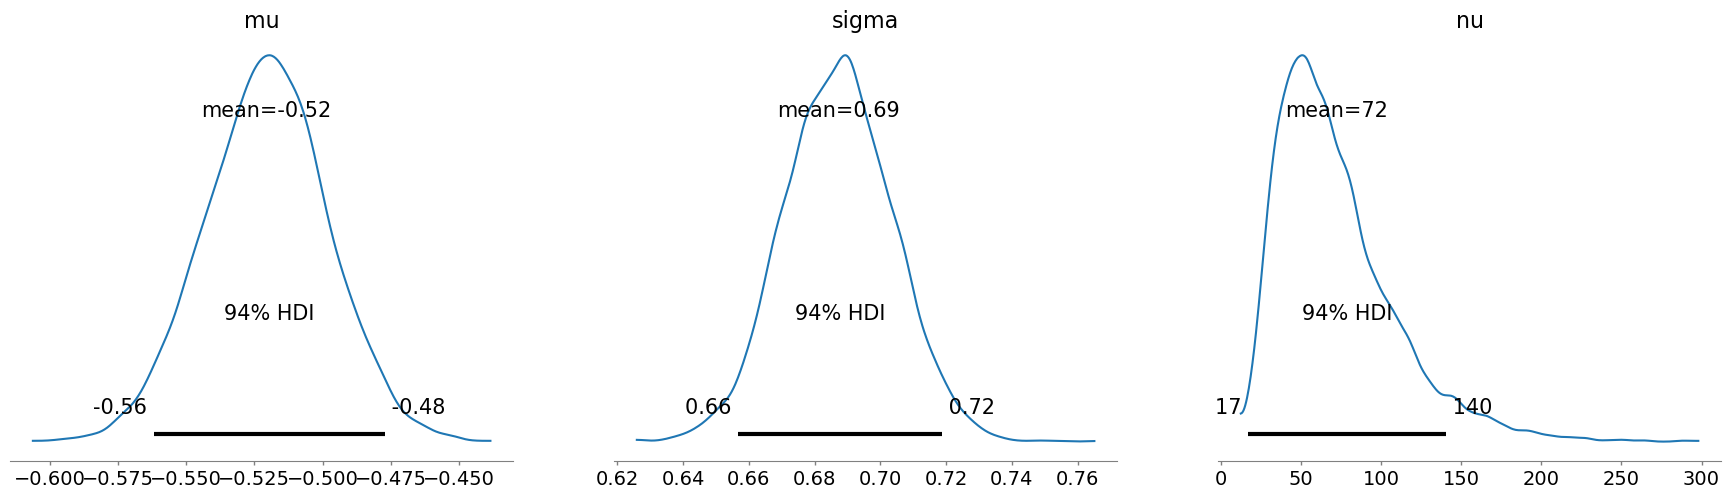

In [25]:
import pymc as pm
import arviz as az

with pm.Model() as model:
    # Prior for the mean error (bias)
    mu = pm.Normal("mu", mu=0, sigma=1)

    # Prior for scale (spread of errors)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Prior for degrees of freedom (t-distribution heaviness)
    nu = pm.Exponential("nu", 1/30)  # Smaller nu = heavier tails

    # Likelihood: observed errors follow Student's t
    obs = pm.StudentT("obs", mu=mu, sigma=sigma, nu=nu, observed=errors)

    # Sampling from the posterior
    trace = pm.sample(2000, return_inferencedata=True)

# Summary and posterior plots
az.summary(trace, var_names=["mu", "sigma", "nu"], kind="stats")
az.plot_posterior(trace, var_names=["mu", "sigma", "nu"])

Output from a Bayesian model of error is above. My question is: how much measured (by LLM) syllable count varies from the true count (from the web). For this, I estimate two parameters—mu and sigma. 

1) Mu is a mean of error, it is -0.53. The interpretation would be that LLM underestimates count by 0.53 syllables on average. Then there is HDI, which is the Highest Density Interval, it is \[-0.57, -0.49\]. 
 

In [97]:
false_ready_df.to_csv("false_ready_df.csv", index=False, header=False)

## Part 2: Counting syllables in sentences and stress marking

Данные из акцентологического корпуса